##**Import library**

In [57]:
rm(list=ls())
set.seed(1234)
library(tidyverse)
library(lubridate)
#install.packages("mlr")
library("mlr")
library("MASS")
library(ggplot2)
#install.packages("randomForest")
library("randomForest")
#install.packages("iml")
library("iml")
#install.packages("gridExtra")
library("gridExtra")
#install.packages("viridis")
library(viridis)
#install.packages("yaImpute")
library("yaImpute")
#install.packages("mgcv")
library(mgcv)

Warning message in rm(list = ls()):
“object 'envir' not found”
Warning message in rm(list = ls()):
“object 'inherits' not found”
Warning message in rm(list = ls()):
“object 'list' not found”
Warning message in rm(list = ls()):
“object 'pos' not found”


#**Regression Problem**

## **Load and process data**

**Data description** <br>
This dataset contains daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C., along with weather and seasonal information. The data was kindly made openly available by Capital-Bikeshare. Fanaee-T and Gama (2013)14 added weather data and season information. The goal is to predict how many bikes will be rented depending on the weather and the day. The data can be downloaded from the UCI Machine Learning Repository.

New features were added to the dataset and not all original features were used for the examples in this book. Here is the list of features that were used:


*  Count of bicycles including both casual and registered users. The count is used as the target in the regression task.
*   The season, either spring, summer, fall or winter.
*   Indicator whether the day was a holiday or not.
*   The year, either 2011 or 2012.
*   Number of days since the 01.01.2011 (the first day in the dataset). This feature was introduced to take account of the trend over time.
*   Indicator whether the day was a working day or weekend.
*   The weather situation on that day. One of: <br>
  1.   clear, few clouds, partly cloudy, cloudy
  2.   mist + clouds, mist + broken clouds, mist + few clouds, mist
  3.   light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds
  4.  heavy rain + ice pallets + thunderstorm + mist, snow + mist
*   Temperature in degrees Celsius.
*   Relative humidity in percent (0 to 100).
*   Wind speed in km per hour.

In [58]:
### Process Bike Data

bike = read.csv("https://github.com/pacayton/DS_397_Interpretable_ML/raw/main/Datasets/Bike_Sharing/day.csv", stringsAsFactors = FALSE)

bike$weekday = factor(bike$weekday, levels=0:6, labels = c('SUN', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT'))
bike$holiday = factor(bike$holiday, levels = c(0,1), labels = c('NO HOLIDAY', 'HOLIDAY'))
bike$workingday = factor(bike$workingday, levels = c(0,1), labels = c('NO WORKING DAY', 'WORKING DAY'))
bike$season = factor(bike$season, levels = 1:4, labels = c('WINTER', 'SPRING', 'SUMMER', 'FALL'))
bike$weathersit = factor(bike$weathersit, levels = 1:3, labels = c('GOOD', 'MISTY', 'RAIN/SNOW/STORM'))
bike$mnth = factor(bike$mnth, levels = 1:12, labels = c('JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'))
bike$yr[bike$yr == 0] = 2011
bike$yr[bike$yr == 1] = 2012
bike$yr = factor(bike$yr)
bike$days_since_2011 = as.numeric(as.Date(bike$dteday)- min(as.Date(bike$dteday)))

# denormalize weather features:
# temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
bike$temp = bike$temp * (39 - (-8)) + (-8)
# atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
bike$atemp = bike$atemp * (50 - (16)) + (16)

#windspeed: Normalized wind speed. The values are divided to 67 (max)
bike$windspeed = 67 * bike$windspeed
#hum: Normalized humidity. The values are divided to 100 (max)
bike$hum = 100 * bike$hum

bike <- dplyr::select(bike, -instant, -dteday, -registered, -casual, -atemp)

bike.features.of.interest = c('season','holiday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'days_since_2011')

In [59]:
head(bike)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
2,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
3,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
4,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
5,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4
6,WINTER,2011,JAN,NO HOLIDAY,THU,WORKING DAY,GOOD,1.604356,51.8261,6.000868,1606,5


In [60]:
tail(bike)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
726,WINTER,2012,DEC,NO HOLIDAY,WED,WORKING DAY,RAIN/SNOW/STORM,3.436651,82.3333,21.208582,441,725
727,WINTER,2012,DEC,NO HOLIDAY,THU,WORKING DAY,MISTY,3.945849,65.2917,23.458911,2114,726
728,WINTER,2012,DEC,NO HOLIDAY,FRI,WORKING DAY,MISTY,3.906651,59.0000,10.416557,3095,727
729,WINTER,2012,DEC,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,3.906651,75.2917,8.333661,1341,728
730,WINTER,2012,DEC,NO HOLIDAY,SUN,NO WORKING DAY,GOOD,4.024151,48.3333,23.500518,1796,729
731,WINTER,2012,DEC,NO HOLIDAY,MON,WORKING DAY,MISTY,2.144151,57.7500,10.374682,2729,730


In [61]:
#Trim features
bike <- bike[,c(2:3,8:10,11:12)]

In [62]:
head(bike)

,yr,mnth,temp,hum,windspeed,cnt,days_since_2011
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,2011,JAN,8.175849,80.5833,10.749882,985,0
2,2011,JAN,9.083466,69.6087,16.652113,801,1
3,2011,JAN,1.229108,43.7273,16.636703,1349,2
4,2011,JAN,1.400000,59.0435,10.739832,1562,3
5,2011,JAN,2.666979,43.6957,12.522300,1600,4
6,2011,JAN,1.604356,51.8261,6.000868,1606,5


In [63]:
#Split data
bike_train <- bike[bike$days_since_2011<585,]
bike_test <- bike[bike$days_since_2011>=585,]

## **Modeling**

### Random forest

In [64]:
bike.task <- makeRegrTask(data = bike_train, target = "cnt")
mod.bike <- mlr::train(mlr::makeLearner(cl = 'regr.randomForest', id = 'bike-rf'), bike.task)
pred.bike = Predictor$new(mod.bike, data = bike_train)
summary(mod.bike)

              Length Class             Mode     
learner        15    regr.randomForest list     
learner.model  17    randomForest      list     
task.desc       9    RegrTaskDesc      list     
subset        585    -none-            numeric  
features        6    -none-            character
factor.levels   2    -none-            list     
time            1    -none-            numeric  
dump            0    -none-            NULL     

## **Partial Dependence Plot**

### One feature

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”


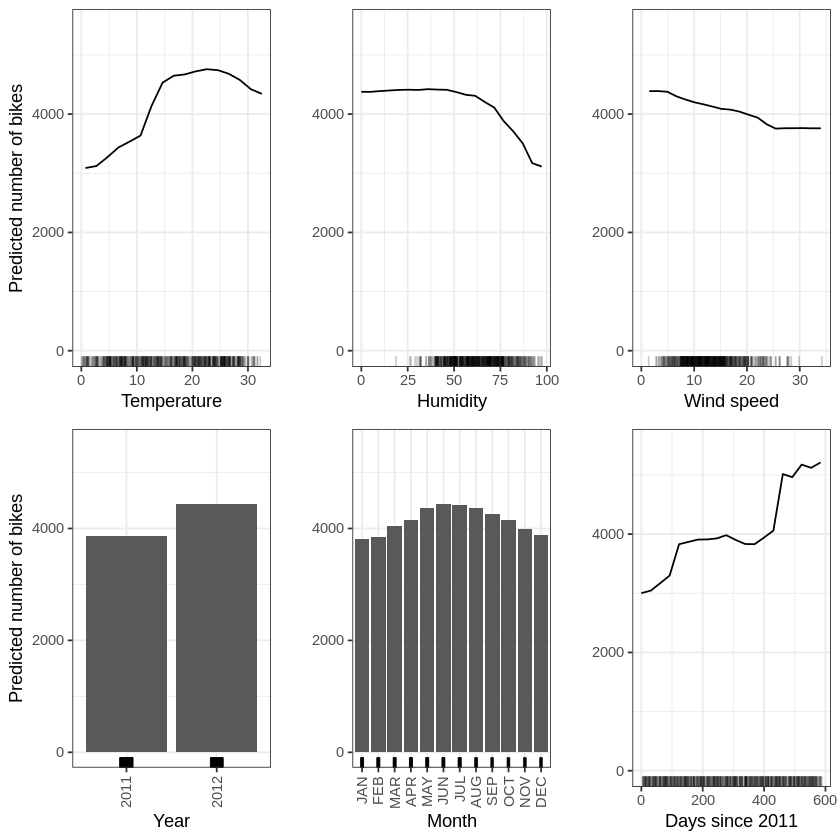

In [65]:
pdp = FeatureEffect$new(pred.bike, "temp", method = "pdp")
p1 = pdp$plot() +
  scale_x_continuous('Temperature', limits = c(0, NA)) +
  scale_y_continuous('Predicted number of bikes', limits = c(0, 5500)) + theme_bw()
pdp$set.feature("hum")
p2 = pdp$plot() +
  scale_x_continuous('Humidity', limits = c(0, NA)) +
  scale_y_continuous('', limits = c(0, 5500)) + theme_bw()
pdp$set.feature("windspeed")
p3 = pdp$plot() +
  scale_x_continuous('Wind speed', limits = c(0, NA)) +
  scale_y_continuous('', limits = c(0, 5500)) + theme_bw()
pdp$set.feature("yr")
p4 = pdp$plot() +
  scale_x_discrete('Year', limits = abbreviate) +
  scale_y_continuous('Predicted number of bikes', limits = c(0, 5500)) + theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
pdp$set.feature("mnth")
p5 = pdp$plot() +
  scale_x_discrete('Month', labels = abbreviate) +
  scale_y_continuous('', limits = c(0, 5500)) + theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
pdp$set.feature("days_since_2011")
p6 = pdp$plot() +
  scale_x_continuous('Days since 2011', limits = c(0,NA)) +
  scale_y_continuous('', limits = c(0, 5500)) + theme_bw()

gridExtra::grid.arrange(p1, p2, p3, p4, p5, p6, nrow = 2, ncol = 3)

### Two features

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


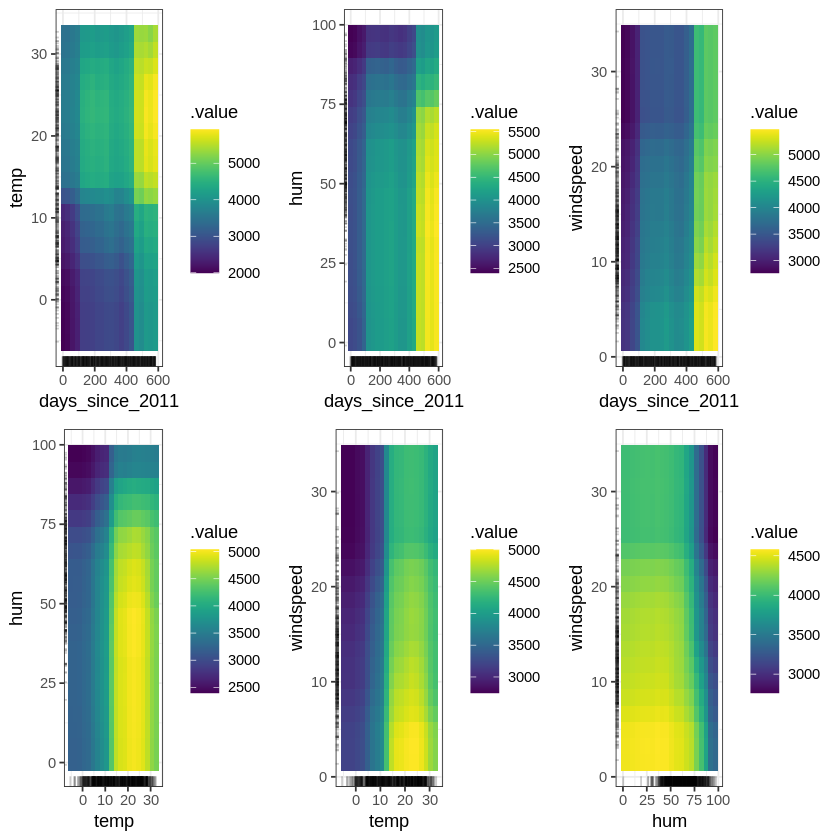

In [66]:
pd = FeatureEffect$new(pred.bike, c("days_since_2011", "temp"), method = "pdp")
z1 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.bike, c("days_since_2011", "hum"), method = "pdp")
z2 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.bike, c("days_since_2011", "windspeed"), method = "pdp")
z3 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.bike, c("temp", "hum"), method = "pdp")
z4 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.bike, c("temp", "windspeed"), method = "pdp")
z5 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.bike, c("hum", "windspeed"), method = "pdp")
z6 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

gridExtra::grid.arrange(z1, z2, z3, z4, z5, z6, nrow = 2, ncol = 3)

## **Accumulated local effects Plot**

### One feature

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`).”


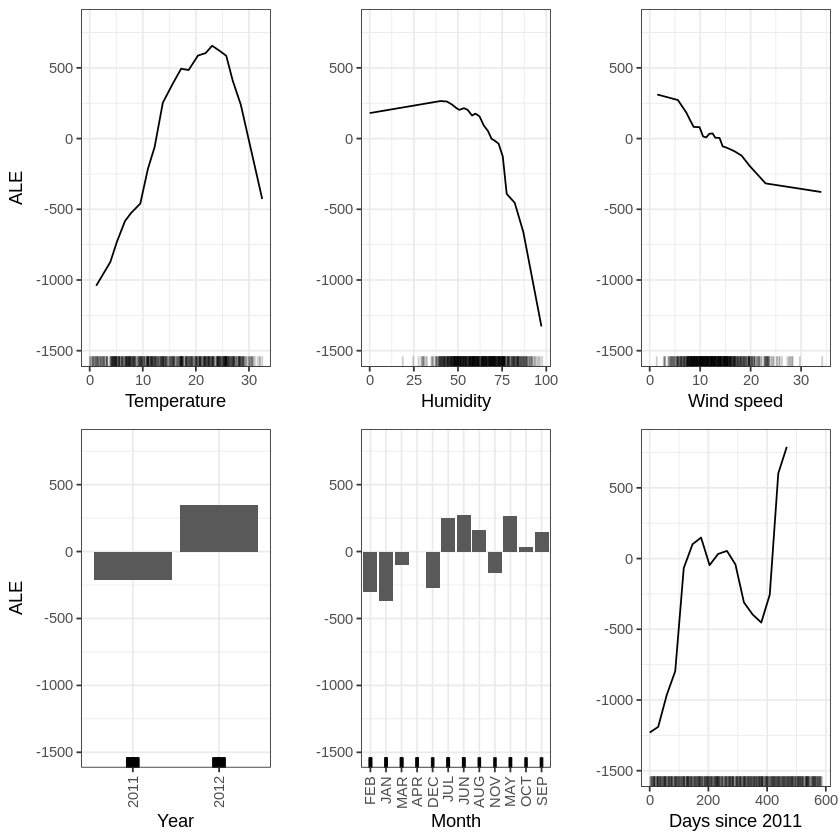

In [67]:
limits = c(-1500, 800)
ale = FeatureEffect$new(pred.bike, "temp", method = "ale")
a1 = ale$plot() +
  scale_x_continuous('Temperature', limits = c(0, NA)) +
  scale_y_continuous('ALE', limits = limits) + theme_bw()
ale$set.feature("hum")
a2 = ale$plot() +
  scale_x_continuous('Humidity', limits = c(0, NA)) +
  scale_y_continuous('', limits = limits) + theme_bw()
ale$set.feature("windspeed")
a3 = ale$plot() +
  scale_x_continuous('Wind speed', limits = c(0, NA)) +
  scale_y_continuous('', limits = limits) + theme_bw()
ale$set.feature("yr")
a4 = ale$plot() +
  scale_x_discrete('Year', limits = abbreviate) +
  scale_y_continuous('ALE', limits = limits) + theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ale$set.feature("mnth")
a5 = ale$plot() +
  scale_x_discrete('Month', labels = abbreviate) +
  scale_y_continuous('', limits = limits) + theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ale$set.feature("days_since_2011")
a6 = ale$plot() +
  scale_x_continuous('Days since 2011', limits = c(0,NA)) +
  scale_y_continuous('', limits = limits) + theme_bw()

gridExtra::grid.arrange(a1, a2, a3, a4, a5, a6, nrow = 2, ncol = 3)

### Two feature

Warning message in merge.data.table(deltas, interval_grid, on = c(".interval1", :
“Unknown argument 'on' has been passed.”
Warning message in merge.data.table(ale, cell.counts.m, on = c(".interval1", ".interval2"), :
“Unknown argument 'on' has been passed.”
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message in merge.data.table(deltas, interval_grid, on = c(".interval1", :
“Unknown argument 'on' has been passed.”
Warning message in merge.data.table(ale, cell.counts.m, on = c(".interval1", ".interval2"), :
“Unknown argument 'on' has been passed.”
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message in merge.data.table(deltas, interval_grid, on = c(".interval1", :
“Unknown argument 'on' has been passed.”
Warning message in merge.data.table(ale, cell.counts.m, on = c(".interval1", ".interval2"), :
“Unknown argument 'on' has been passed.”
Scale for fill i

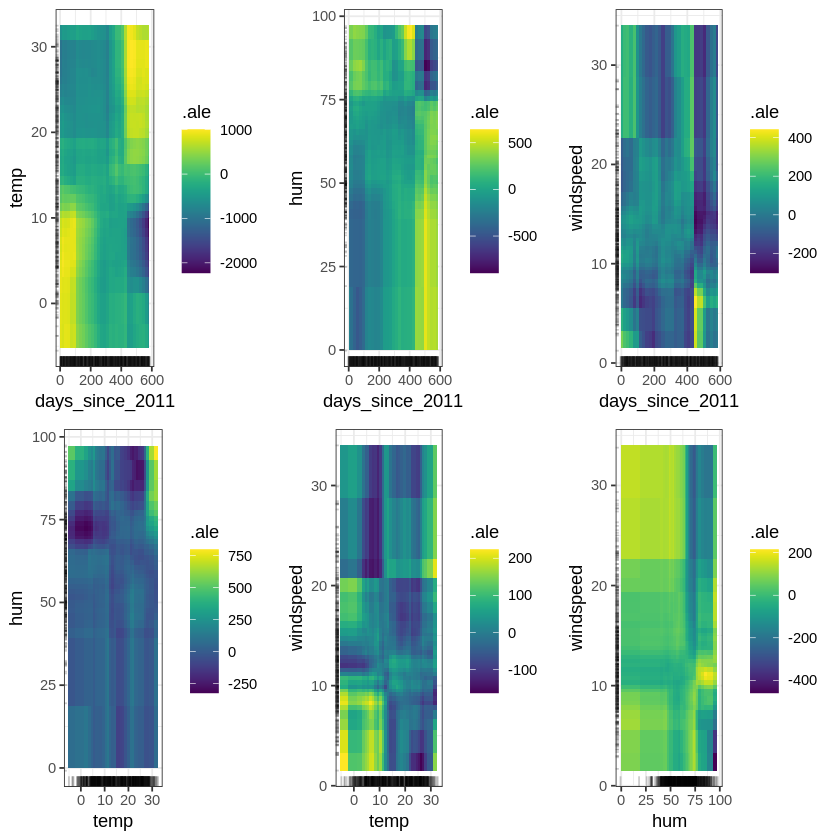

In [68]:
pd = FeatureEffect$new(pred.bike, c("days_since_2011", "temp"), grid.size = 30, method = "ale")
az1 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.bike, c("days_since_2011", "hum"), grid.size = 30, method = "ale")
az2 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.bike, c("days_since_2011", "windspeed"), grid.size = 30, method = "ale")
az3 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.bike, c("temp", "hum"), grid.size = 30, method = "ale")
az4 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.bike, c("temp", "windspeed"), grid.size = 30, method = "ale")
az5 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.bike, c("hum", "windspeed"), grid.size = 30, method = "ale")
az6 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

gridExtra::grid.arrange(az1, az2, az3, az4, az5, az6, nrow = 2, ncol = 3)

## **Feature Interaction Statistics**

### Overall interaction H^2

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


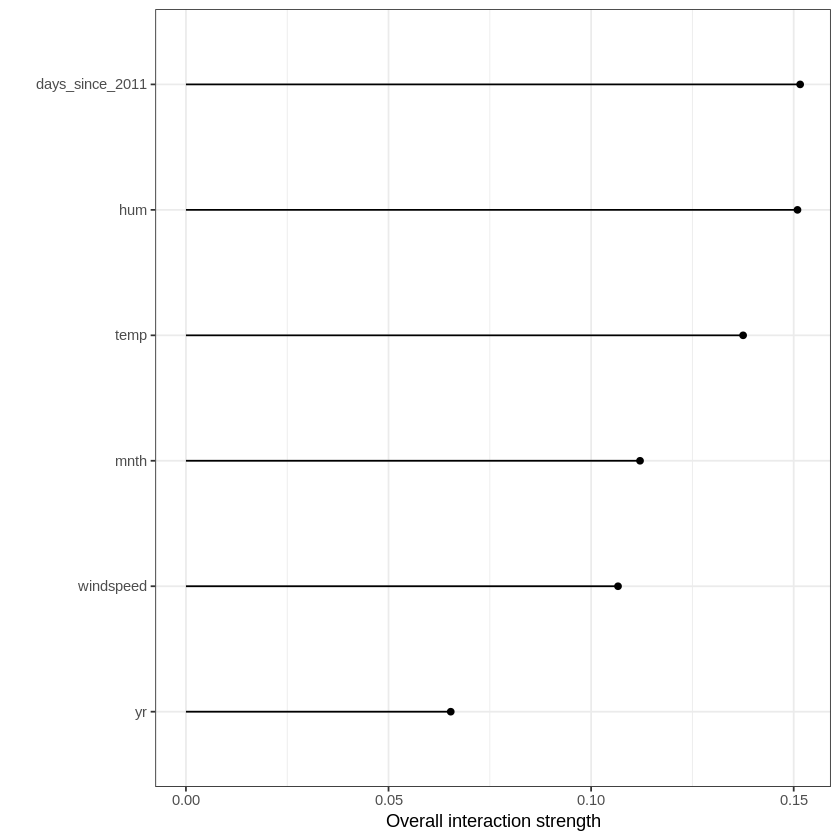

In [69]:
ia = Interaction$new(pred.bike, grid.size = 50)
plot(ia) +
 scale_y_discrete("") + theme_bw()

### Two-variable interaction H^2

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


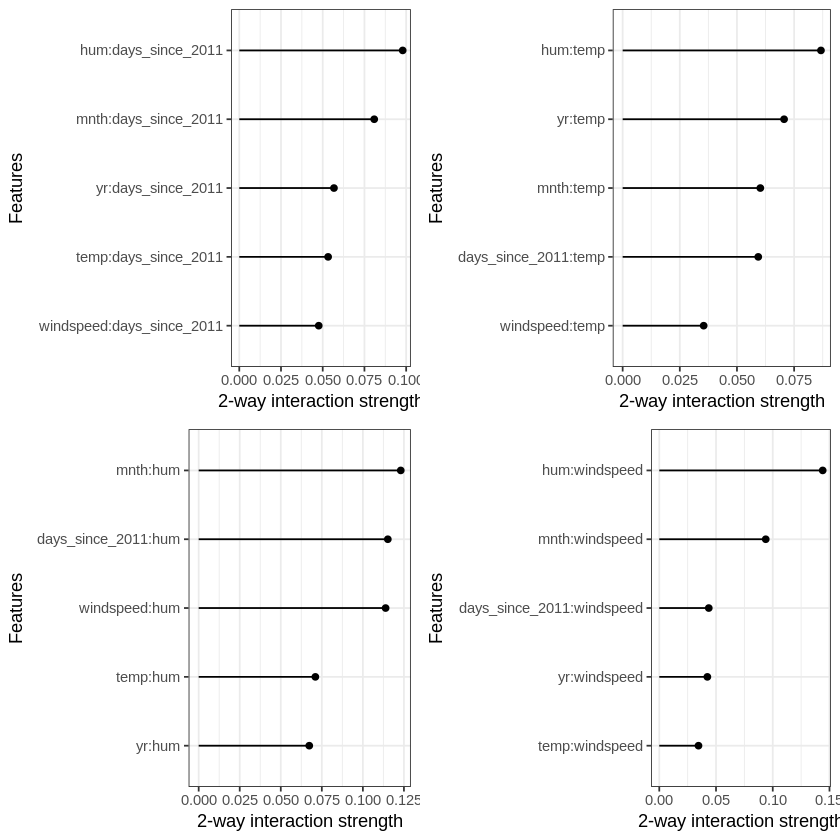

In [70]:
ia21 = Interaction$new(pred.bike, grid.size = 100, feature = "days_since_2011")
aa1 = plot(ia21) + scale_x_continuous("2-way interaction strength") + theme_bw()

ia22 = Interaction$new(pred.bike, grid.size = 100, feature = "temp")
aa2 = plot(ia22) + scale_x_continuous("2-way interaction strength") + theme_bw()

ia23 = Interaction$new(pred.bike, grid.size = 100, feature = "hum")
aa3 = plot(ia23) + scale_x_continuous("2-way interaction strength") + theme_bw()

ia24 = Interaction$new(pred.bike, grid.size = 100, feature = "windspeed")
aa4 = plot(ia24) + scale_x_continuous("2-way interaction strength") + theme_bw()

gridExtra::grid.arrange(aa1, aa2, aa3, aa4, nrow = 2, ncol = 2)

## **Permutation Feature Importance**

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


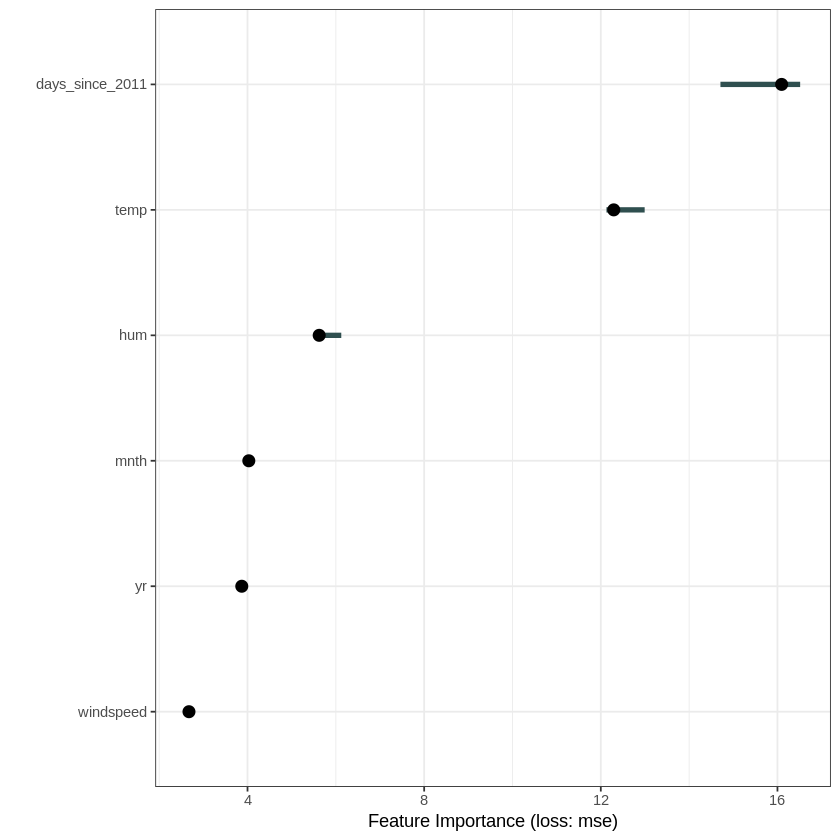

In [71]:
importance = FeatureImp$new(pred.bike, loss = 'mse')
plot(importance) +
   scale_y_discrete("") + theme_bw()

## **Global Surrogate Model**

In [72]:
gam.bike = gam(cnt ~ s(days_since_2011) + temp + hum + windspeed + yr + mnth, data = bike_train)
gam.pred = predict(gam.bike,bike_train)
rf.pred = getPredictionResponse(predict(mod.bike,bike.task))
num = sum((gam.pred-rf.pred)^2)
den = sum((rf.pred-mean(rf.pred))^2)
R = 1- (num/den)
print(R)

[1] 0.9108767


In [73]:
summary(gam.bike)


Family: gaussian 
Link function: identity 

Formula:
cnt ~ s(days_since_2011) + temp + hum + windspeed + yr + mnth

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4266.443   1004.320   4.248 2.52e-05 ***
temp          84.097      9.411   8.936  < 2e-16 ***
hum          -25.639      2.310 -11.098  < 2e-16 ***
windspeed    -50.819      6.388  -7.956 9.89e-15 ***
yr2012      2400.855   1318.591   1.821   0.0692 .  
mnthFEB     -172.749    244.888  -0.705   0.4808    
mnthMAR     -233.334    391.163  -0.597   0.5511    
mnthAPR     -386.635    513.631  -0.753   0.4519    
mnthMAY      -11.744    613.546  -0.019   0.9847    
mnthJUN       50.507    690.140   0.073   0.9417    
mnthJUL     -337.349    756.580  -0.446   0.6559    
mnthAUG      -92.284    832.129  -0.111   0.9117    
mnthSEP      -96.358    929.645  -0.104   0.9175    
mnthOCT      -86.585   1030.607  -0.084   0.9331    
mnthNOV      322.889   1129.370   0.286   0.7751    
mnthDEC   

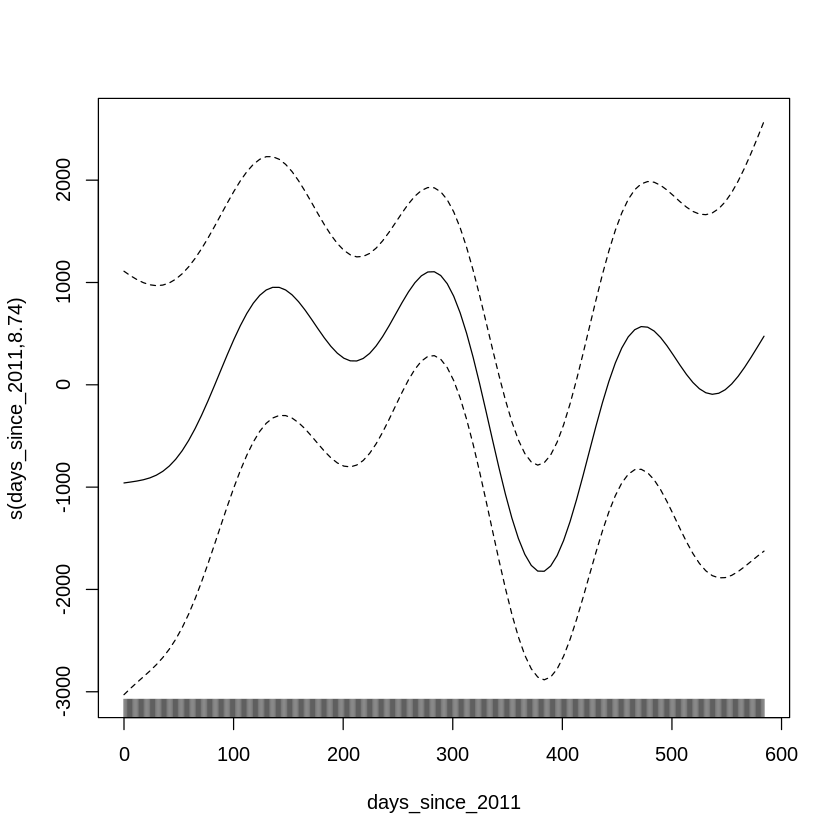

In [97]:
plot(gam.bike, pages = 1)

In [74]:
gam.pred.test = predict(gam.bike,bike_test)
rf.pred.test = pred.bike$predict(bike_test)
mse1 <- mean((bike_test$cnt - gam.pred.test)^2)
mse2 <- mean((bike_test$cnt - rf.pred.test$.prediction)^2)
print(paste(mse1,"&",mse2))

[1] "8397700.13817761 & 1673309.18368155"


#**Classification Problem**

## **Load and process data**

**Data description** <br>
The cervical cancer dataset contains indicators and risk factors for predicting whether a woman will get cervical cancer. The features include demographic data (such as age), lifestyle, and medical history. The data can be downloaded from the UCI Machine Learning repository and is described by Fernandes, Cardoso, and Fernandes (2017).

The subset of data features used in the book’s examples are:

* Age in years
* Number of sexual partners
* First sexual intercourse (age in years)
* Number of pregnancies
* Smoking yes or no
* Smoking (in years)
* Hormonal contraceptives yes or no
* Hormonal contraceptives (in years)
* Intrauterine device yes or no (IUD)
* Number of years with an intrauterine device (IUD)
* Has patient ever had a sexually transmitted disease (STD) yes or no
* Number of STD diagnoses
* Time since first STD diagnosis
* Time since last STD diagnosis
* The biopsy results “Healthy” or “Cancer”. Target outcome.

In [75]:
### Process cervical cancer Data

cervical = read.csv("https://github.com/pacayton/DS_397_Interpretable_ML/raw/refs/heads/main/Datasets/Cervical_Cancer_Risk_Factors/risk_factors_cervical_cancer.csv", na.strings = c('?'), stringsAsFactors = FALSE)

  ## subset variables
  cervical = dplyr::select(cervical, Age, Number.of.sexual.partners, First.sexual.intercourse,
  Smokes, Hormonal.Contraceptives, STDs..number.,Biopsy)

  mlr::makeClassifTask(id='cervical', data = cervical, target = 'Biopsy')

head(cervical)

Supervised task: cervical
Type: classif
Target: Biopsy
Observations: 858
Features:
   numerics     factors     ordered functionals 
          6           0           0           0 
Missings: TRUE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
  0   1 
803  55 
Positive class: 0

,Age,Number.of.sexual.partners,First.sexual.intercourse,Smokes,Hormonal.Contraceptives,STDs..number.,Biopsy
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,18,4,15,0,0,0,0
2,15,1,14,0,0,0,0
3,34,1,NA,0,0,0,0
4,52,5,16,1,1,0,0
5,46,3,21,0,1,0,0
6,42,3,23,0,0,0,0


In [76]:
tail(cervical)

,Age,Number.of.sexual.partners,First.sexual.intercourse,Smokes,Hormonal.Contraceptives,STDs..number.,Biopsy
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
853,43,3,17,0,1,0,0
854,34,3,18,0,0,0,0
855,32,2,19,0,1,0,0
856,25,2,17,0,1,0,0
857,33,2,24,0,1,0,0
858,29,2,20,0,1,0,0


In [77]:
cervical_train <- cervical[1:686,]
cervical_test <- cervical[687:858,]

#remove instance with missing data
cervical_train <- cervical_train[complete.cases(cervical_train),]
cervical_test <- cervical_test[complete.cases(cervical_test),]

#Checking
makeClassifTask(id='cervical_train', data = cervical_train, target = 'Biopsy')
makeClassifTask(id='cervical_test', data = cervical_test, target = 'Biopsy')

Supervised task: cervical_train
Type: classif
Target: Biopsy
Observations: 574
Features:
   numerics     factors     ordered functionals 
          6           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
  0   1 
532  42 
Positive class: 0

Supervised task: cervical_test
Type: classif
Target: Biopsy
Observations: 139
Features:
   numerics     factors     ordered functionals 
          6           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
  0   1 
130   9 
Positive class: 0

## **Modeling**

### Random forest

In [78]:
cervical.task = makeClassifTask(data = cervical_train, target = "Biopsy")
mod = mlr::train(mlr::makeLearner(cl = 'classif.randomForest', id = 'cervical-rf', predict.type = 'prob'), cervical.task)
pred.cervical = Predictor$new(mod, data = cervical_train, class = "1")

## **Partial Dependence Plot**

### One feature

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


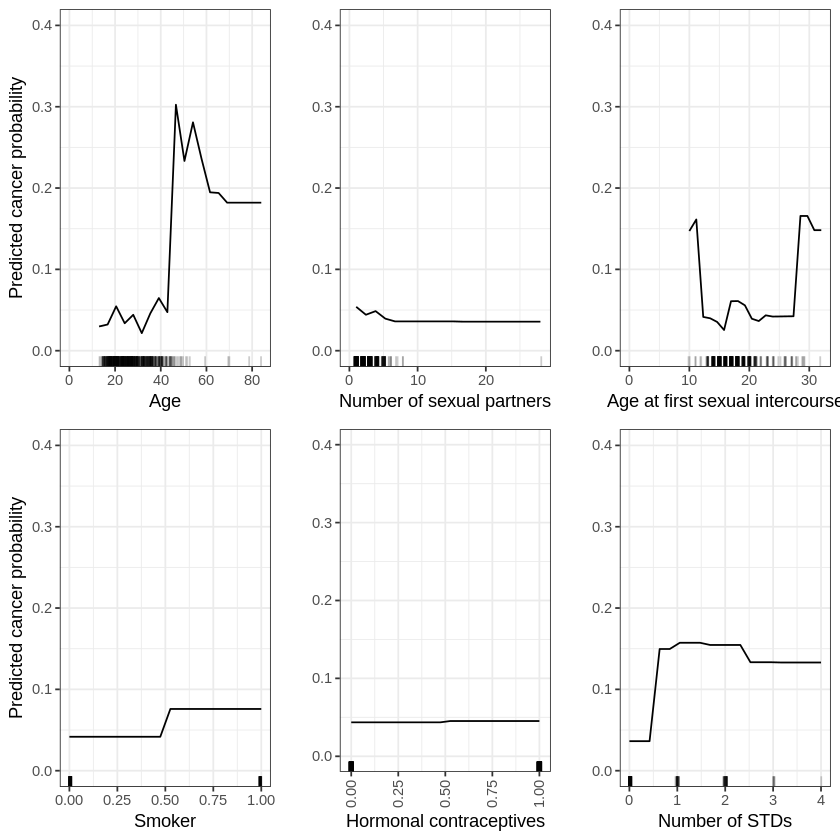

In [79]:
pdp = FeatureEffect$new(pred.cervical, "Age", method = "pdp")
p1 = pdp$plot() +
  scale_x_continuous('Age', limits = c(0, NA)) +
  scale_y_continuous('Predicted cancer probability', limits = c(0, 0.4)) + theme_bw()
pdp$set.feature("Number.of.sexual.partners")
p2 = pdp$plot() +
  scale_x_continuous('Number of sexual partners', limits = c(0, NA)) +
  scale_y_continuous('', limits = c(0, 0.4)) + theme_bw()
pdp$set.feature("First.sexual.intercourse")
p3 = pdp$plot() +
  scale_x_continuous('Age at first sexual intercourse', limits = c(0, NA)) +
  scale_y_continuous('', limits = c(0, 0.4)) + theme_bw()
pdp$set.feature("Smokes")
p4 = pdp$plot() +
  scale_x_continuous('Smoker', limits = c(0,1)) +
  scale_y_continuous('Predicted cancer probability', limits = c(0, 0.4)) + theme_bw()
pdp$set.feature("Hormonal.Contraceptives")
p5 = pdp$plot() +
  scale_x_continuous('Hormonal contraceptives') +
  scale_y_continuous('', limits = c(0, 0.4)) + theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
pdp$set.feature("STDs..number.")
p6 = pdp$plot() +
  scale_x_continuous('Number of STDs', limits = c(0,NA)) +
  scale_y_continuous('', limits = c(0, 0.4)) + theme_bw()

gridExtra::grid.arrange(p1, p2, p3, p4, p5, p6, nrow = 2, ncol = 3)

### Two feature

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


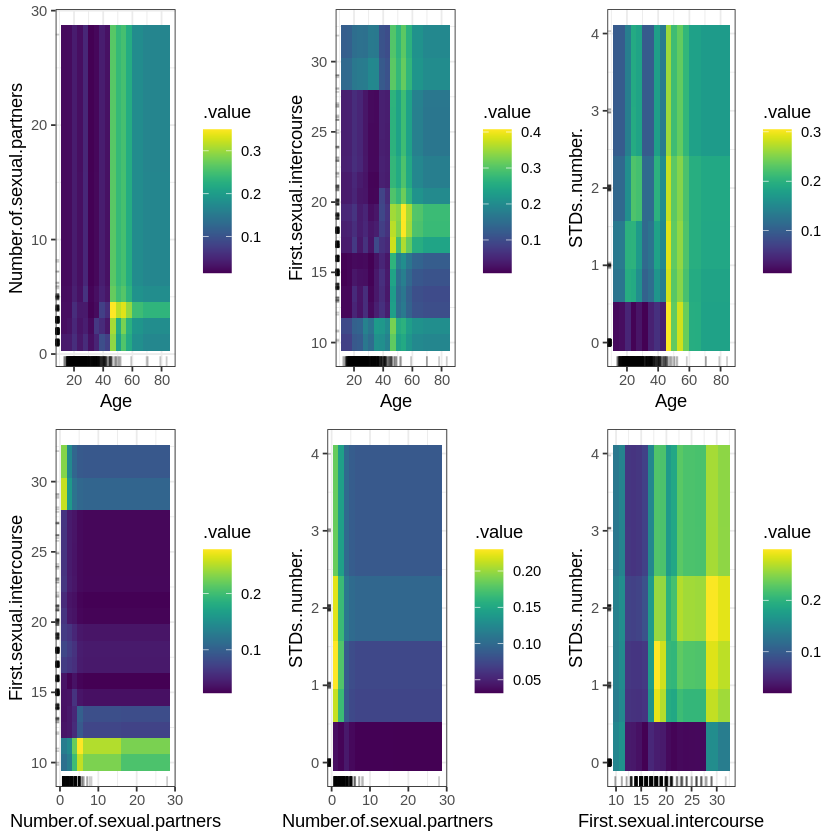

In [80]:
pd = FeatureEffect$new(pred.cervical, c("Age", "Number.of.sexual.partners"), method = "pdp")
z1 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.cervical, c("Age", "First.sexual.intercourse"), method = "pdp")
z2 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.cervical, c("Age", "STDs..number."), method = "pdp")
z3 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.cervical, c("Number.of.sexual.partners", "First.sexual.intercourse"), method = "pdp")
z4 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.cervical, c("Number.of.sexual.partners", "STDs..number."), method = "pdp")
z5 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.cervical, c("First.sexual.intercourse", "STDs..number."), method = "pdp")
z6 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

gridExtra::grid.arrange(z1, z2, z3, z4, z5, z6, nrow = 2, ncol = 3)

## **Accumulated local effects Plot**

### One feature

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


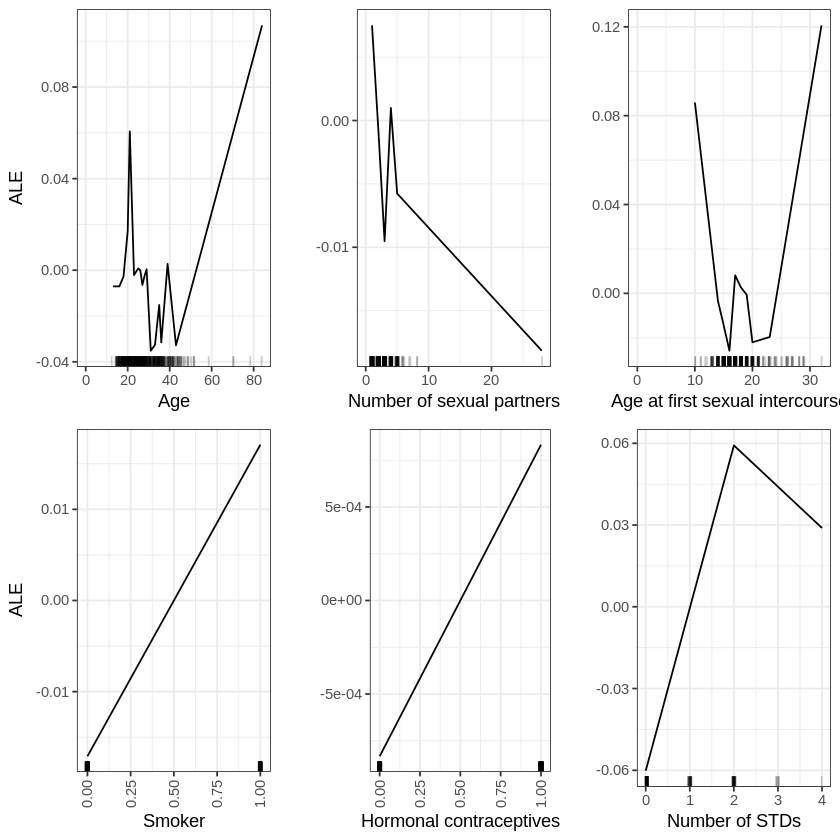

In [98]:
ale = FeatureEffect$new(pred.cervical, "Age", method = "ale")
a1 = ale$plot() +
  scale_x_continuous('Age', limits = c(0, NA)) +
  scale_y_continuous('ALE') + theme_bw()
ale$set.feature("Number.of.sexual.partners")
a2 = ale$plot() +
  scale_x_continuous('Number of sexual partners', limits = c(0, NA)) +
  scale_y_continuous('') + theme_bw()
ale$set.feature("First.sexual.intercourse")
a3 = ale$plot() +
  scale_x_continuous('Age at first sexual intercourse', limits = c(0, NA)) +
  scale_y_continuous('') + theme_bw()
ale$set.feature("Smokes")
a4 = ale$plot() +
  scale_x_continuous('Smoker') +
  scale_y_continuous('ALE') + theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ale$set.feature("Hormonal.Contraceptives")
a5 = ale$plot() +
  scale_x_continuous('Hormonal contraceptives') +
  scale_y_continuous('') + theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
ale$set.feature("STDs..number.")
a6 = ale$plot() +
  scale_x_continuous('Number of STDs', limits = c(0,NA)) +
  scale_y_continuous('') + theme_bw()

gridExtra::grid.arrange(a1, a2, a3, a4, a5, a6, nrow = 2, ncol = 3)

### Two feature

Warning message in merge.data.table(deltas, interval_grid, on = c(".interval1", :
“Unknown argument 'on' has been passed.”
Warning message in merge.data.table(ale, cell.counts.m, on = c(".interval1", ".interval2"), :
“Unknown argument 'on' has been passed.”
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message in merge.data.table(deltas, interval_grid, on = c(".interval1", :
“Unknown argument 'on' has been passed.”
Warning message in merge.data.table(ale, cell.counts.m, on = c(".interval1", ".interval2"), :
“Unknown argument 'on' has been passed.”
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message in merge.data.table(deltas, interval_grid, on = c(".interval1", :
“Unknown argument 'on' has been passed.”
Warning message in merge.data.table(ale, cell.counts.m, on = c(".interval1", ".interval2"), :
“Unknown argument 'on' has been passed.”
Scale for fill i

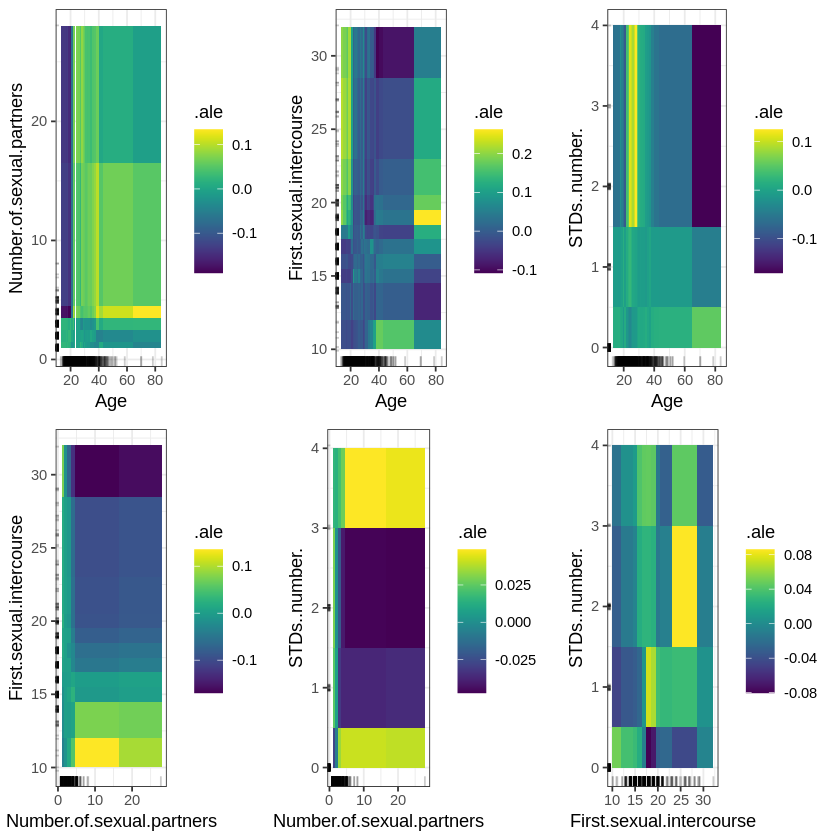

In [83]:
pd = FeatureEffect$new(pred.cervical, c("Age", "Number.of.sexual.partners"), grid.size = 30, method = "ale")
az1 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.cervical, c("Age", "First.sexual.intercourse"), grid.size = 30, method = "ale")
az2 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.cervical, c("Age", "STDs..number."), grid.size = 30, method = "ale")
az3 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.cervical, c("Number.of.sexual.partners", "First.sexual.intercourse"), grid.size = 30, method = "ale")
az4 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.cervical, c("Number.of.sexual.partners", "STDs..number."), grid.size = 30, method = "ale")
az5 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

pd = FeatureEffect$new(pred.cervical, c("First.sexual.intercourse", "STDs..number."), grid.size = 30, method = "ale")
az6 = pd$plot() +
  scale_fill_viridis(option = "D") + theme_bw()

gridExtra::grid.arrange(az1, az2, az3, az4, az5, az6, nrow = 2, ncol = 3)

## **Feature Interaction Statistics**

### Overall interaction H^2

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


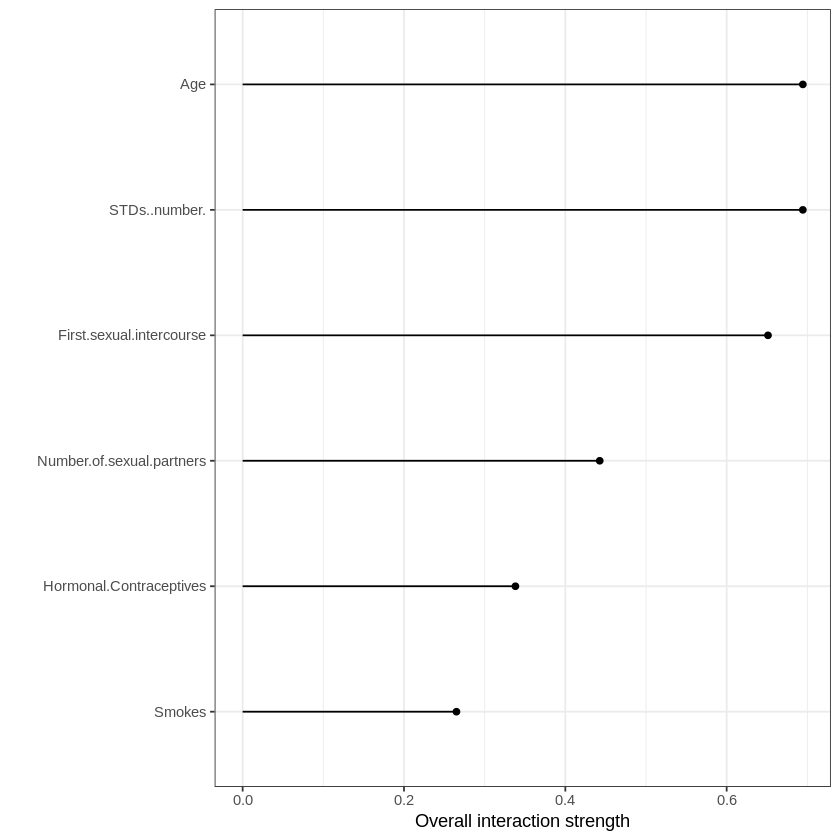

In [86]:
ia = Interaction$new(pred.cervical, grid.size = 50)
plot(ia) +
 scale_y_discrete("") + theme_bw()

### Two-variable interaction H^2

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


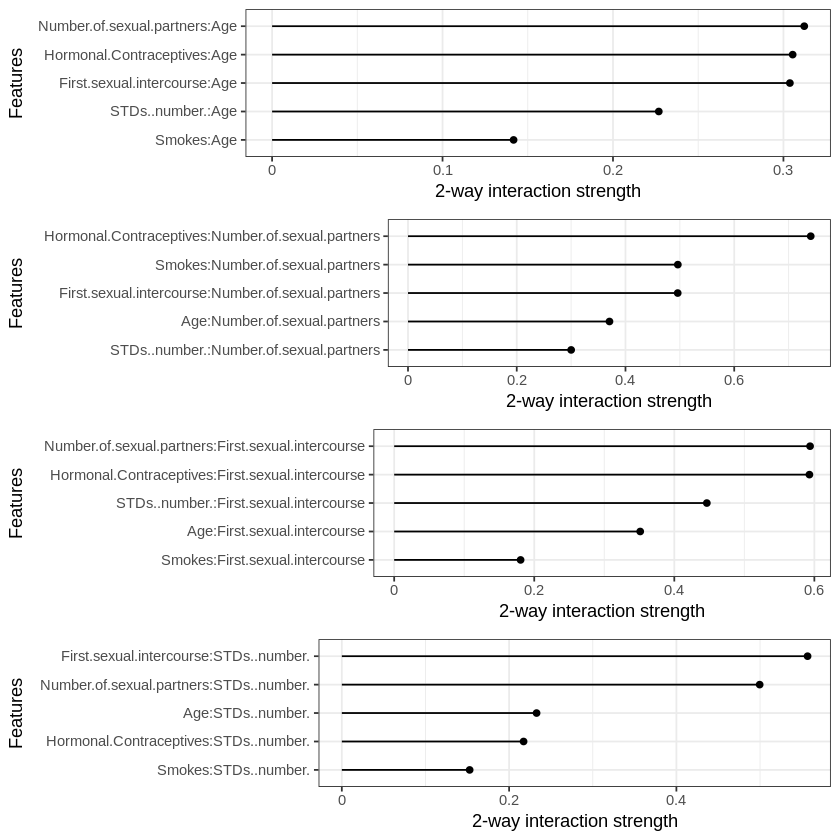

In [93]:
ia21 = Interaction$new(pred.cervical, grid.size = 100, feature = "Age")
aa1 = plot(ia21) + scale_x_continuous("2-way interaction strength",labels = abbreviate) + theme_bw()

ia22 = Interaction$new(pred.cervical, grid.size = 100, feature = "Number.of.sexual.partners")
aa2 = plot(ia22) + scale_x_continuous("2-way interaction strength",labels = abbreviate) + theme_bw()

ia23 = Interaction$new(pred.cervical, grid.size = 100, feature = "First.sexual.intercourse")
aa3 = plot(ia23) + scale_x_continuous("2-way interaction strength",labels = abbreviate) + theme_bw()

ia24 = Interaction$new(pred.cervical, grid.size = 100, feature = "STDs..number.")
aa4 = plot(ia24) + scale_x_continuous("2-way interaction strength",labels = abbreviate) + theme_bw()

gridExtra::grid.arrange(aa1, aa2, aa3, aa4, nrow = 4, ncol = 1)

## **Permutation Feature Importance**

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


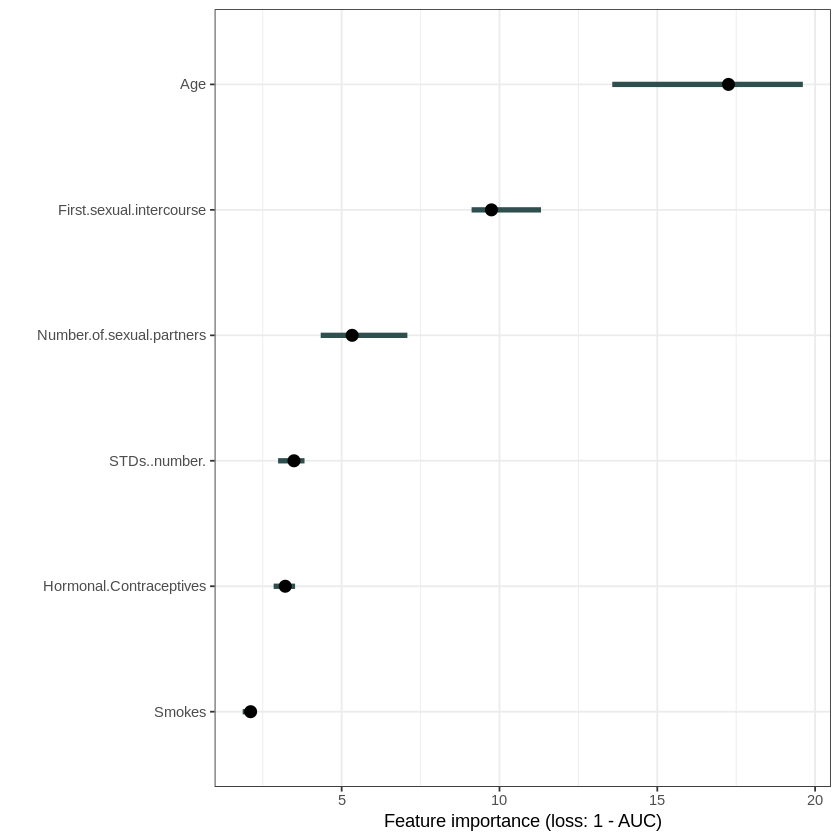

In [92]:
auc_error = function(actual, predicted) 1 - Metrics::auc(actual, predicted)
importance = FeatureImp$new(pred.cervical, loss = auc_error)
plot(importance) + scale_x_continuous("Feature importance (loss: 1 - AUC)") +
   scale_y_discrete("") + theme_bw()

## **Global Surrogate Model**

In [99]:
gam.cervical = gam(Biopsy ~ s(Age) + Number.of.sexual.partners	+ Hormonal.Contraceptives + Smokes + STDs..number. + s(First.sexual.intercourse), data = cervical_train, family = binomial())
gam.pred = predict(gam.cervical,cervical_train)
rf.pred = getPredictionResponse(predict(mod,cervical.task))
num = sum((gam.pred-rf.pred)^2)
den = sum((rf.pred-mean(rf.pred))^2)
R = 1- (num/den)
print(R)

Warning message in Ops.factor(gam.pred, rf.pred):
“‘-’ not meaningful for factors”
Warning message in mean.default(rf.pred):
“argument is not numeric or logical: returning NA”
Warning message in Ops.factor(rf.pred, mean(rf.pred)):
“‘-’ not meaningful for factors”


[1] NA


In [100]:
summary(gam.cervical)


Family: binomial 
Link function: logit 

Formula:
Biopsy ~ s(Age) + Number.of.sexual.partners + Hormonal.Contraceptives + 
    Smokes + STDs..number. + s(First.sexual.intercourse)

Parametric coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -2.66113    0.49072  -5.423 5.86e-08 ***
Number.of.sexual.partners -0.14257    0.15073  -0.946   0.3442    
Hormonal.Contraceptives    0.23782    0.37356   0.637   0.5244    
Smokes                     0.08291    0.47157   0.176   0.8604    
STDs..number.              0.40320    0.23250   1.734   0.0829 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                            edf Ref.df Chi.sq p-value
s(Age)                      6.2  6.861 11.663   0.106
s(First.sexual.intercourse) 1.0  1.000  0.371   0.543

R-sq.(adj) =  0.0197   Deviance explained = 6.61%
UBRE = -0.46858  Scale est. = 1         n = 574

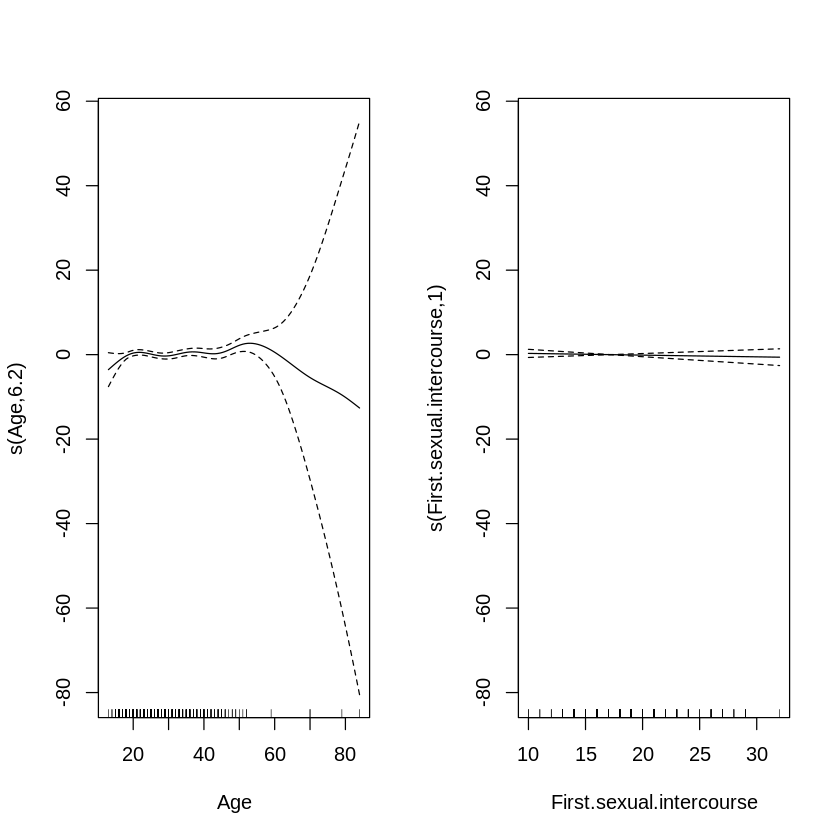

In [101]:
plot(gam.cervical, pages = 1)